# Libraries

In [ ]:
#Audio Processing Libraries
import librosa
import librosa.display
from scipy import signal

#For Playing Audios
import IPython.display as ipd

#Array Processing
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Display the confusion matrix
from sklearn.metrics import confusion_matrix

#Deal with .pkl files
import pickle

#Create a dataframe
import pandas as pd

#Transform and encode the categorical targets
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

#Split dataset
from sklearn.model_selection import train_test_split

import os

# Exploring Dataset

## Ambulance

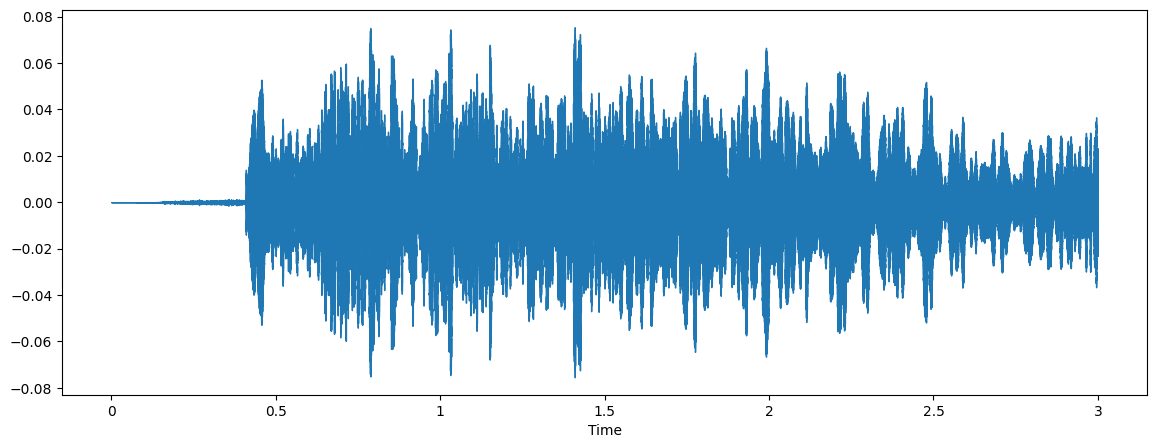

In [ ]:
filename = "sounds/ambulance/sound_1.wav"
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(filename)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(filename)

## Firetruck

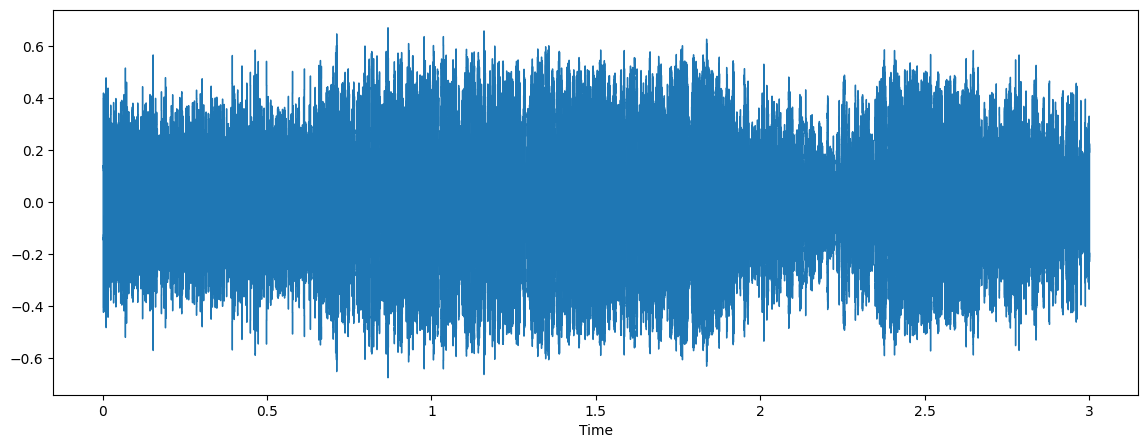

In [ ]:
filename = "sounds/firetruck/sound_201.wav"
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(filename)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(filename)

## Traffic

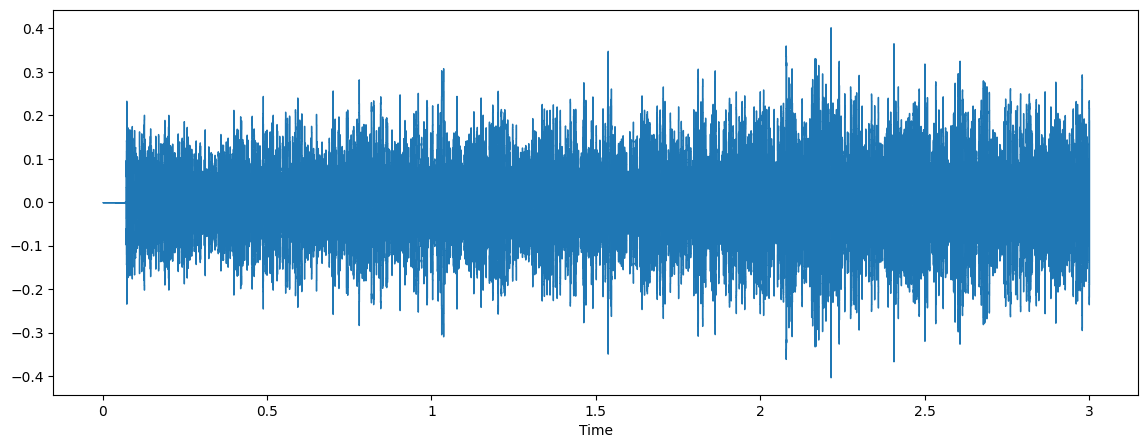

In [ ]:
filename = "sounds/traffic/sound_401.wav"
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(filename)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(filename)

# Data Preprocessing

## Using the function features_extractor to get a 80 MFCCs from each audio

In [ ]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=80)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    return mfccs_scaled_features

## Now we iterate through every audio file and extract features using Mel-Frequency Cepstral Coefficients

In [1]:
audio_dataset_path = 'sounds/'

extracted_features = []
for path in os.listdir(audio_dataset_path):
    for file in os.listdir(audio_dataset_path+path+"/"):
        if file.lower().endswith(".wav"):
            file_name = audio_dataset_path+path+"/"+file
            data = features_extractor(file_name)
            extracted_features.append([data, path])

NameError: name 'os' is not defined

# Save the data frame into a .pkl file

In [ ]:
f = open('./Extracted_Features.pkl', 'wb')
pickle.dump(extracted_features, f)
f.close()

# Read the Extracted_Features from the .pkl file

In [ ]:
f = open('./Extracted_Features.pkl', 'rb')
Data = pickle.load(f)
f.close()

# Transform Data into a dataframe

In [ ]:
df = pd.DataFrame(Data,columns=['feature','class'])
df.head()

,feature,class
0,"[-100.950966, 93.389, -63.255177, -1.4709233, ...",ambulance
1,"[-529.2778, 96.091225, -46.660313, -12.780944,...",ambulance
2,"[-205.98355, 128.79228, -19.970928, 9.641362, ...",ambulance
3,"[-118.98806, 113.261086, -38.593113, -1.789974...",ambulance
4,"[-217.5137, 159.17299, -50.161335, -13.604832,...",ambulance


In [ ]:
df['class'].value_counts()

ambulance    200
traffic      200
firetruck    200
Name: class, dtype: int64

# Splitting the data into train and test sets

In [ ]:
X = np.array(df['feature'].tolist())
Y = np.array(df['class'].tolist())

In [ ]:
X.shape

(600, 80)

In [ ]:
Y.shape

(600,)

# Label Encoding

In [ ]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(Y))

In [ ]:
Y[0]

'ambulance'

In [ ]:
y[0]

array([1., 0., 0.], dtype=float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y, shuffle=True)

In [ ]:
y_train.shape

(480, 3)

# Display the shape of each splits

In [ ]:
X_train.shape

(480, 80)

In [ ]:
X_test.shape

(120, 80)

In [ ]:
y_test.shape

(120, 3)

# Model Building

In [ ]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras import backend as K
from sklearn import metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from datetime import datetime

# Grid Search

In [ ]:
# def display_cv_results(search_results):
#     print('Best score = {:.4f} using {}'.format(search_results.best_score_, search_results.best_params_))
#     means = search_results.cv_results_['mean_test_score']
#     stds = search_results.cv_results_['std_test_score']
#     params = search_results.cv_results_['params']
#     for mean, stdev, param in zip(means, stds, params):
#         print('mean test accuracy +/- std = {:.4f} +/- {:.4f} with: {}'.format(mean, stdev, param))

In [ ]:
# ## Trianing my model
# model = cnn()
# model = KerasClassifier(build_fn=model, verbose=1)

# param_grid = {
#     'batch_size': [32, 64],
#     'epochs': [100, 200],
#     'optimizer': ['rmsprop', 'adam'],
#     'activation': ['relu'],
#     'dropout_rate': [0.0, 0.2, 0.4, 0.5]
# }

# start = datetime.now()

# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train_features, y_train).history

# # print out results
# print('time for grid search = {:.0f} sec'.format(datetime.now() - start))
# display_cv_results(grid_result)

# CNN

In [ ]:
X_train_features  = X_train.reshape(len(X_train),-1,1)
X_test_features = X_test.reshape(len(X_test),-1,1)
print("Reshaped Array Size", X_train_features.shape)

Reshaped Array Size (480, 80, 1)


In [ ]:
X_train.shape

(480, 80)

In [ ]:
def cnn(optimizer="adam", activation="relu", dropout_rate=0.5):
    K.clear_session()
    inputs = Input(shape=(X_train_features.shape[1], X_train_features.shape[2]))

    #First Conv1D layer
    conv = Conv1D(3, 13, padding='same', activation=activation)(inputs)
    if dropout_rate != 0:
        conv = Dropout(dropout_rate)(conv)
    conv = MaxPooling1D(2)(conv)

    #Second Conv1D layer
    conv = Conv1D(16, 11, padding='same', activation=activation)(conv)
    if dropout_rate != 0:
        conv = Dropout(dropout_rate)(conv)
    conv = MaxPooling1D(2)(conv)

    #MaxPooling 1D
    conv = GlobalMaxPool1D()(conv)

    #Dense Layer
    conv = Dense(16, activation=activation)(conv)
    outputs = Dense(y_test.shape[1], activation='softmax')(conv)

    model = Model(inputs, outputs)
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['acc'])
    return model

In [ ]:
model_cnn = cnn(optimizer="adam", activation="relu", dropout_rate=0)
model_cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 80, 3)             42        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 40, 3)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 16)            544       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 16)            0         
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272   

2022-09-04 19:42:16.471780: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


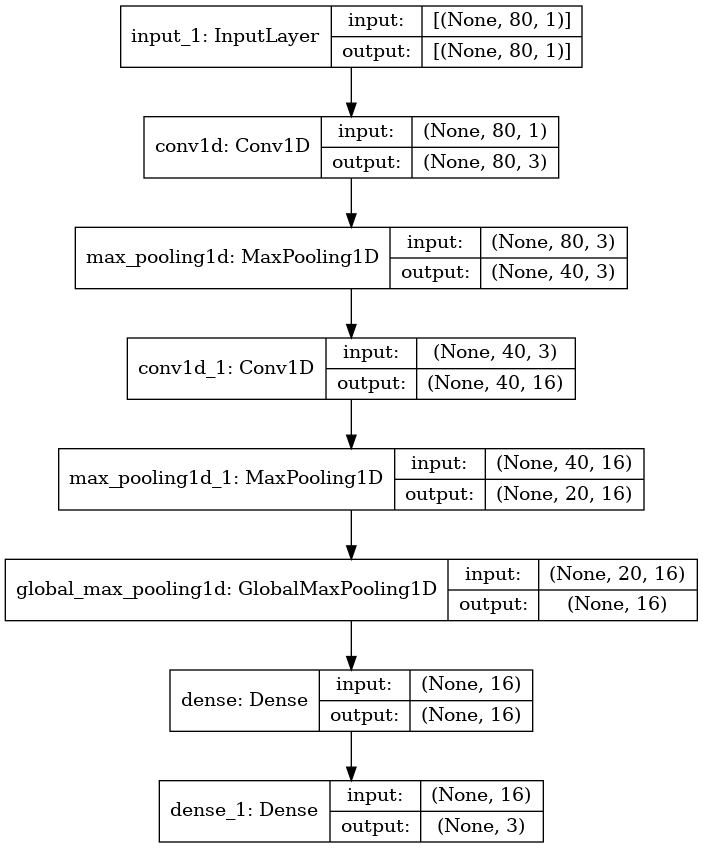

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_cnn, show_shapes=True, show_layer_names=True)

In [ ]:
early_stop = EarlyStopping(monitor = 'val_accuracy', mode ='max',
                          patience = 10, restore_best_weights = True)

history = model_cnn.fit(X_train_features, y_train, epochs = 200,
                       callbacks = [early_stop],
                       batch_size = 64, validation_data = (X_test_features, y_test))

2022-09-04 19:56:48.972997: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
8/8 [==============================] - 1s 47ms/step - loss: 5.2646 - acc: 0.3417 - val_loss: 3.3359 - val_acc: 0.3750
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 2.8279 - acc: 0.3708 - val_loss: 1.7266 - val_acc: 0.5167
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 1.2311 - acc: 0.4563 - val_loss: 0.6669 - val_acc: 0.5417
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.7930 - acc: 0.5333 - val_loss: 0.6394 - val_acc: 0.5833
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.5357 - acc: 0.7083 - val_loss: 0.4239 - val_acc: 0.7833
Epoch 6/200
8/8 [==============================] - 0s 10ms/step - loss: 0.4356 - acc: 0.8271 - val_loss: 0.3561 - val_acc: 0.7917
Epoch 7/200
8/8 [==============================] - 0s 11ms/step - loss: 0.3484 - acc: 0.8271 - val_loss: 0.3199 - val_acc: 0.8250
Epoch 8/200
8/8 [==============================] - 0s 10ms/step - loss: 0.3203 - acc: 0.83

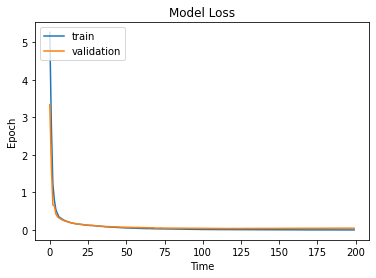

In [ ]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Time')
plt.ylabel('Epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

In [ ]:
_, acc = model_cnn.evaluate(X_test_features, y_test)
print("Test Accuracy : ", acc)

4/4 [==============================] - 0s 3ms/step - loss: 0.0491 - acc: 0.9750
Test Accuracy :  0.9750000238418579


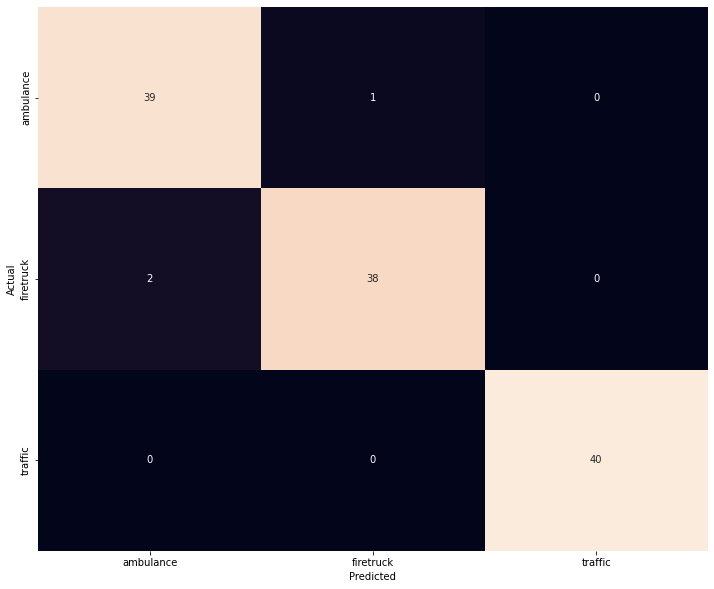

In [ ]:
y_pred = model_cnn.predict(X_test_features)

conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
model_cnn.save('./CNN_Model')

2022-09-04 19:59:00.583321: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# LSTM

In [ ]:
x_train_features  = X_train.reshape(len(X_train),-1, 80)
x_test_features = X_test.reshape(len(X_test), -1, 80)
print("Reshaped Array Size", x_train_features.shape)

Reshaped Array Size (480, 1, 80)


In [ ]:
def lstm(x_tr):
    K.clear_session()
    inputs = Input(shape=(x_tr.shape[1], x_tr.shape[2]))
    #lstm
    x = LSTM(128)(inputs)
    x = Dropout(0.5)(x)
    #dense
    x = Dense(64, activation='relu')(x)
    x = Dense(y_test.shape[1], activation='softmax')(x)
    model = Model(inputs, x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [ ]:
model_lstm = lstm(x_train_features)
model_lstm.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 80)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               107008    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 115,459
Trainable params: 115,459
Non-trainable params: 0
_________________________________________________________________


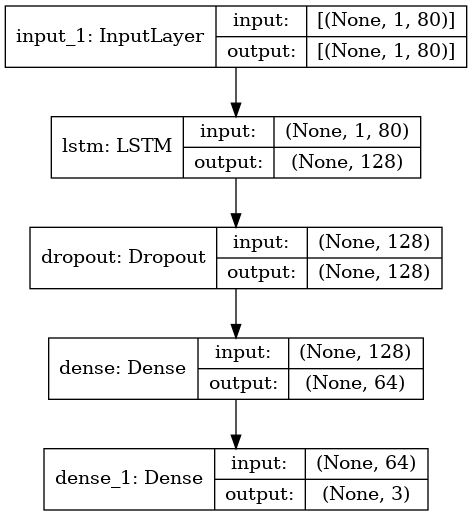

In [ ]:
plot_model(model_lstm, show_shapes=True, show_layer_names=True)

In [ ]:
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model_lstm.fit(x_train_features, y_train, epochs = 1000,
                        callbacks = [mc],
                        batch_size = 64, validation_data = (x_test_features, y_test))

Epoch 1/1000
8/8 [==============================] - 3s 88ms/step - loss: 0.6103 - acc: 0.5083 - val_loss: 0.4794 - val_acc: 0.8750

Epoch 00001: val_acc improved from -inf to 0.87500, saving model to best_model.hdf5
Epoch 2/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.4566 - acc: 0.8042 - val_loss: 0.3614 - val_acc: 0.9000

Epoch 00002: val_acc improved from 0.87500 to 0.90000, saving model to best_model.hdf5
Epoch 3/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.3619 - acc: 0.8875 - val_loss: 0.2628 - val_acc: 0.9167

Epoch 00003: val_acc improved from 0.90000 to 0.91667, saving model to best_model.hdf5
Epoch 4/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.2887 - acc: 0.8917 - val_loss: 0.1969 - val_acc: 0.9250

Epoch 00004: val_acc improved from 0.91667 to 0.92500, saving model to best_model.hdf5
Epoch 5/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.2344 - acc: 0.9021 - val_loss: 0.1508 - val_acc: 0.9

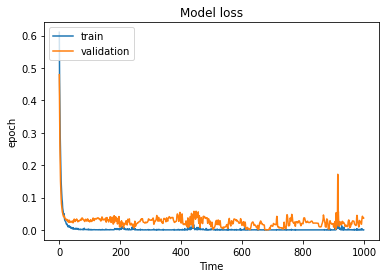

In [ ]:
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Time')
plt.ylabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [ ]:
_,acc = model_lstm.evaluate(x_test_features, y_test)
print("Accuracy:", acc)

4/4 [==============================] - 0s 4ms/step - loss: 0.0366 - acc: 0.9917
Accuracy: 0.9916666746139526


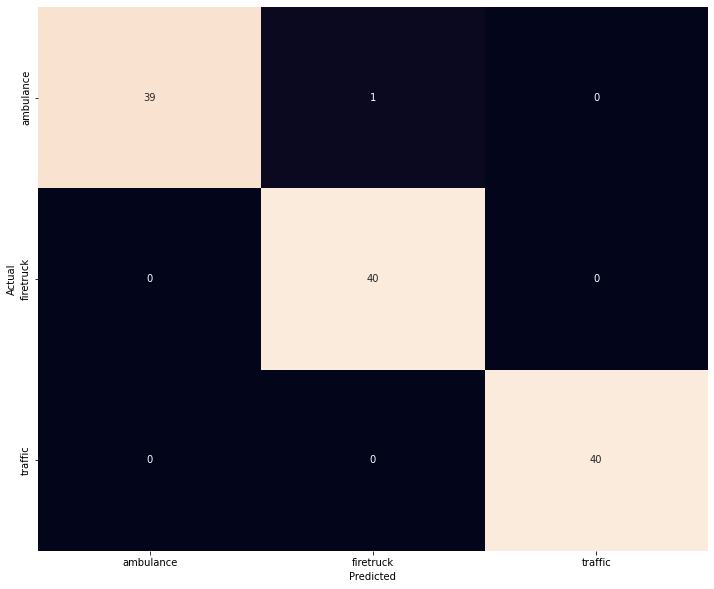

In [ ]:
y_pred = model_lstm.predict(x_test_features)

conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
model_lstm.save('./LSTM')